# Frictional Unemployment
####by Omar A. Guerrero, University of Oxford
In these notes we will closely follow Pissarides' framework as presented in his book: Equilibrium Unemployment Theory. Specifically, we concentrate in the simplest model (chapter 1.1), where we do not know the actual number of vacancies, but instead the ratio $\theta = V/U$ of vacancies $V$ to unemployed $U$. By fixing $\theta$, we can obtain analytical predictions about the steady state unemployment rate, which we use as benchmark to compare the output of our model. As we progress through other notes, we will develop other aspects of Pissarides' framework, up to the point where it is more convenient to abandon the rational equilibrium perspective, for a more realistic specification. However, the journey through Pissarides' world should serve as an example of the power and generality of agent-computing economic models when implemented in a careful and systematic way.

## Libraries

In [29]:
from __future__ import division # forces a division of integers to return a float (in order to avoid errors)
%matplotlib inline
import random as rd # tools to genrate random numbers and more
import matplotlib.pyplot as plt # we will use this to visualize the model's output

## Parameters
We introduce the new parameter $\theta=V/U$, which measures the availability of job opportunities as a proportion of the number of agents looking for them. This is also termed market tightness.

In [30]:
L = 1000 # number of workers
N = 100 # number of firms
Lambda = 0.1 # the exogenous source of unemployment, also known as the separation rate
w = .8 # the wage generated (we will assume it to be fixed)
Theta = .5 # the V/U ratio, also known as market tightness
Alpha = .5 # a parameter of the aggregate matching function, explained in the Market section
max_t = 500 # maximum number of steps to be ran in the simulation

## Agents

### Workers
When a worker is unemployed, she will not always find a firm that will hire her. Instead, the market determines the probability of her match by using the latest information about the aggregate unemployment rate collected by the stats agent.

In [31]:
class Worker():
    
    # gives birth (initializes) to a single worker
    def __init__(self, id, Lambda=Lambda, w=w, employer=None):
        self.id = id # the id of the worker
        self.Lambda = Lambda # the separation rate of the worker
        self.w = w # the wage of the worker
        self.employer = employer # the firm for which the agent works
    
    # checks if the agent works for a firm and returns False if she is unemployed and True otherwise
    def is_employed(self):
        return not self.employer==None
    
    # sets the wage
    def set_wage(self, w):
        self.w = w
    
    # sets the employer
    def set_employer(self, firm):
        self.employer = firm
        
    # specifies what the agent does in each step of the simulation
    def step(self, t):
        rand = rd.random() # draw a random number
        if self.is_employed(): # check employment status
            # the probability of becoming unemployed is the average of the separation rates of the worker and the firm.
            # This is a bit of an arbitrary assumption but can be modified later. The point is to capture the effect
            # that each counterpart has in the process of unemployment. Since we will assume homogenous agents, this
            # specification does not change from simply assuming the general Lambda to be the only source of unemployment.
            if rand < (self.Lambda + self.employer.Lambda)/2:
                market.separation(self) # peform separation in the market
        else:
            if rand < market.matching_proba(): # check if the labor market frictions allow the match
                firm = market.pick_firm() # pick a firm at random
                wage = w # determine the wage
                market.hiring(self, firm, wage, t) # perform the hiring in the market

### Firms

In [32]:
class Firm():
    
    # initializes the firm
    def __init__(self, id, Lambda=Lambda):
        self.id = id
        self.Lambda = Lambda
        self.book = {}
    
    # register a newly hired worker with her wage and the period of hiring
    def hire(self, worker, wage, step):
        self.book[worker] = (wage, step)
    
    # remove the separated worker from the book
    def separate(self, worker):
        self.book.pop(worker)
    
    # compute the size (in number of employees)
    def size(self):
        return len(self.book)
    
    # specifies what the firm does in each step of the simulation. For now it does nothing
    def step(self, t):
        return # do nothing

### Market
The market holds the obscure mechanism that motivates the aggregate matching functions. Therefore, we specify the function with the desired properties of homogeneity-degree one and being increasing in both unemployment and vacancies. Since we will also solve Pissarides model analytically to use it as our benchmark, we assume the simplest function: $M=\alpha U + (1-\alpha)V$, where $M$ is the number of job seekers who successfully find a vacancy. Then, the probability that a job seeker is matched to a firm with a vacancy is $p=M/U$.

In [33]:
class Market():
    
    # register a hiring in both the firm and the worker attributes
    def hiring(self, worker, firm, wage, step):
        worker.set_employer(firm)
        worker.set_wage(w)
        firm.hire(worker, wage, step)
    
    # register a separation in both the firm and the worker attributes
    def separation(self, worker):
        firm = worker.employer
        firm.separate(worker)
        worker.set_employer(None)
        worker.set_wage(0)
       
    # the aggregate matching function
    def matches(self, U=1):
        return Alpha*U + (1-Alpha)*(U*Theta)
    
    # the probability of a match
    def matching_proba(self):
        U = stats.data['U']
        return self.matches(U)/U
    
    # pick a firm at random
    def pick_firm(self):
        return rd.choice(firms)

### Statistics Bureau
The stats agent now knows Pissarides' model and employs it to estimate the steady state unemployment rate of the economy with knowledge of $\theta$. In this way, we can encapsulate all computations of Pissarides' model in the statistics bureau, which we late use to compare with the model's output.

In [34]:
class Stats():
    
    # initializes the statistics bureau
    def __init__(self):
        self.data = {} # a dictionary that holds different data structures
        self.data['u'] = 1 # the latest unemployment rate
        self.data['U'] = 1 # the latest unemployment level
        self.data['ts_u'] = [] # list that stores the time series of the unemployment rate
        
    # counts the number of employed
    def count_employed(self):
        return sum([worker.is_employed() for worker in workers])
    
    # counts the number of unemployed
    def count_unemployed(self):
        return sum([not worker.is_employed() for worker in workers])
    
    # computes the unemployment rate
    def unemployment_rate(self):
        return self.count_unemployed()/L
    
    # computes the average wage
    def average_wage(self):
        return sum([worker.w for worker in workers if worker.is_employed()])/self.count_employed()
    
    # computes the average firm size
    def average_firm_size(self):
        return sum([firm.size() for firm in firms])/N
    
    # what the statistics bureau does every period
    def step(self):
        self.data['U'] = self.count_unemployed()
        self.data['u'] = self.data['U']/L
        self.data['ts_u'].append(self.data['u'])
    
    # the theoretical unemployment rate from Pissarides' model
    def theory_u(self):
        return Lambda/( Lambda + Theta*(Alpha/Theta + 1 - Alpha) )

## Execution

### Initialization

In [35]:
workers = [Worker(id) for id in range(L)] # list of workers parameterized acording to the Parameters section
firms = [Firm(id) for id in range(N)] # list of firms parameterized acording to the Parameters section
agents = workers + firms # make a joint list of workers and firms
rd.shuffle(agents) # randomize the order to the agents in the list
market = Market() # our market object
stats = Stats() # our statistics bureau

## Execution
We add a call to the statistics bureau step(method)

In [36]:
for t in range(max_t):
    [agent.step(t) for agent in agents]
    stats.step() # the stats agent perform its duty

## Plotting

### Unemployment Rate

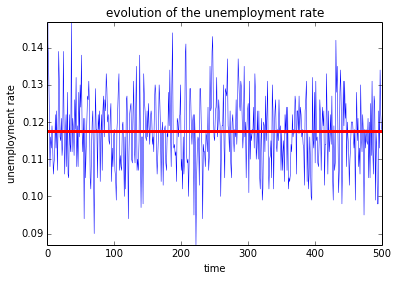

In [37]:
plt.plot(stats.data['ts_u'], linewidth=.5) # plot the time series collected by the stats agent
plt.plot([stats.theory_u() for i in range(max_t)], 'r', linewidth=3) # plot the analytical prediction
plt.ylim([min(stats.data['ts_u'][1::]), max(stats.data['ts_u'][1::])])
plt.xlabel('time')
plt.ylabel('unemployment rate')
plt.title('evolution of the unemployment rate')

### Firm Size Distribution
A histogram of the firm size distribution.

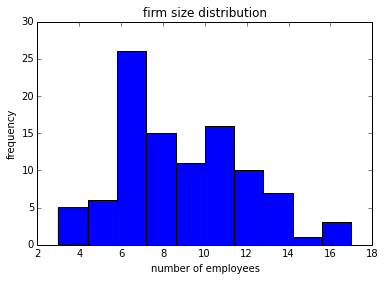

In [38]:
plt.hist([firm.size() for firm in firms]) # plot the time series collected by the stats agent
plt.xlabel('number of employees')
plt.ylabel('frequency')
plt.title('firm size distribution')

## Conclusion
We introduces the concept of the aggregate matching function in order to integrate frictional unemployment in the model. In the agent-computing model, the matching rate is updated every period by using the latest unemployment rate. The output of the model matches the analytical prediction, although the process through which firms and workers find each other is obscure.